(1)셀프 카메라를 다양한 각도에서 촬영하면서 스티커를 반복해서 적용해 보세요.

(2) 문제점이 무엇인지 최대한 자세하게 기록해 보세요. 여러분이 생각한 문제점을 해결하기 위한 방법은 분명 존재합니다!

오늘 만든 스티커앱에서 생각해볼 수 있는 문제점은 다음과 같습니다.

- 얼굴 각도에 따라 스티커가 어떻게 변해야할까요?
- 멀리서 촬영하면 왜 안될까요? 옆으로 누워서 촬영하면 왜 안될까요?
- 실행 속도가 중요할까요?
- 스티커앱을 만들 때 정확도가 얼마나 중요할까요?

In [1]:
import cv2
import dlib
import matplotlib.pyplot as plt
import numpy as np

print(cv2.__version__)
print(dlib.__version__)

4.5.3
19.22.1


# 얼굴 검출 & 랜드마크 검출 하기

## 이미지 불러오기

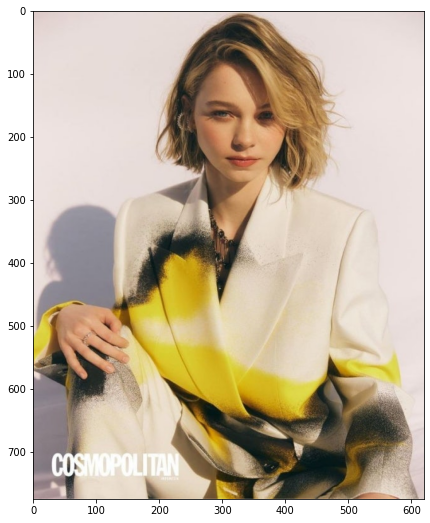

In [2]:
img_bgr = cv2.imread('./emma_fr.png')    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # RGB 순서를 변환합니다.


# 이미지 출력
plt.figure(figsize=(7,9))
plt.imshow(img_rgb)
plt.show()

## 얼굴 검출

In [3]:
detector_hog = dlib.get_frontal_face_detector() # 기본 얼굴 감지기 초기화

In [4]:
# 얼굴 감지 영역 좌표
dlib_rects = detector_hog(img_show, 1)
print(dlib_rects) 

rectangles[[(253, 133) (408, 288)]]


In [5]:
l = dlib_rects[0].left() # 왼쪽
t = dlib_rects[0].top() # 위쪽
r = dlib_rects[0].right() # 오른쪽
b = dlib_rects[0].bottom() # 아래쪽
print(l,t,r,b)

253 133 408 288


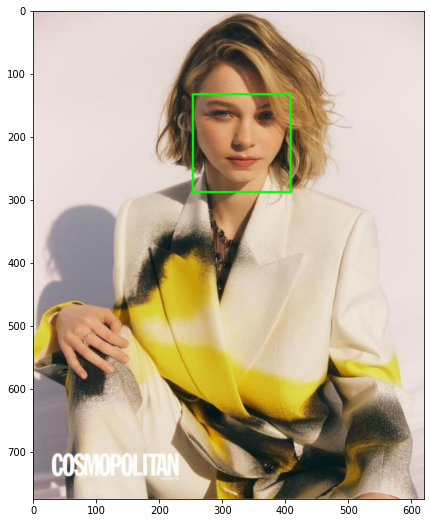

In [6]:
 # 시작점의 좌표와 종료점 좌표로 직각 사각형을 그리기
cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

# 이미지 출력
plt.figure(figsize=(7,9))
img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 랜드마크 검출

In [7]:
# landmark 모델 경로
model_path = '/aiffel/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'

# dlib 라이브러리의 shape_predictor 함수를 이용하여 모델 불러오기
landmark_predictor = dlib.shape_predictor(model_path)

# 모든 landmark의 위치정보 points 변수에 저장
points = landmark_predictor(img_show, dlib_rects[0])
    
# 각각의 landmark 위치정보를 (x,y) 형태로 변환하여 list_points 리스트로 저장
list_points = list(map(lambda p: (p.x, p.y), points.parts()))

# 원소 개수 확인
print(len(list_points))

68


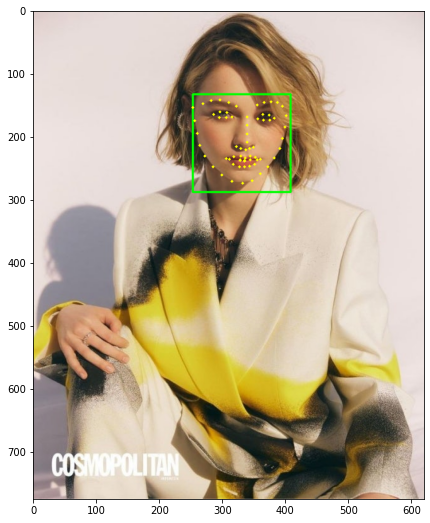

In [8]:
for point in list_points:
    cv2.circle(img_show, point, 2, (0, 255, 255), -1)

# 이미지 출력
plt.figure(figsize=(7,9))
img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

# 스티커 적용 위치 확인하기

## 스티커 위치 정하기

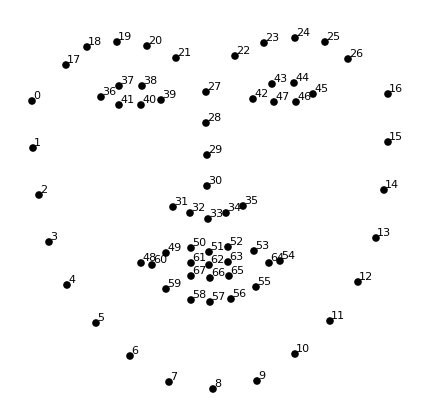

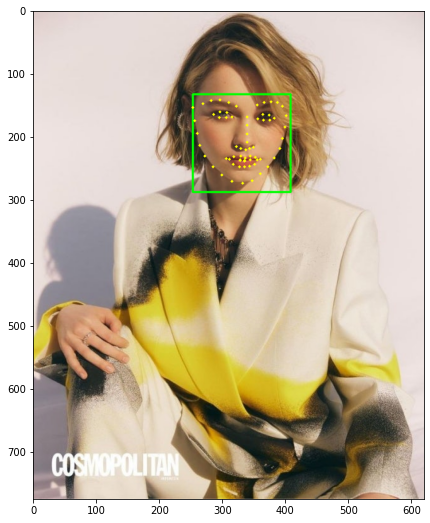

In [9]:
# 이미지 출력
plt.figure(figsize=(7,9))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

- 실제 사진을 참고하여 고양이코(스티커)의 두께를 생각하면 코 끝부분인 30번보다 콧등 밑 부분인 29번이 적절해 보인다.

In [10]:
# x, y는 콧등 위치와 동일
x = list_points[29][0]
y = list_points[29][1]

# w, h는 얼굴 영역 크기과 동일
w = h = dlib_rects[0].width()

In [11]:
x, y, w, h

(339, 196, 156, 156)

In [12]:
# 원본 이미지에서 이미지 좌표
refined_x = x - w // 2
refined_y = y

print (f'(x,y) : ({refined_x},{refined_y})')

(x,y) : (261,196)


## 스티커 불러오기

In [14]:
# 스티커 이미지 불러오기
img_sticker = cv2.imread('./cat-whiskers.png')
# img_sticker = cv2.cvtColor(img_sticker, cv2.COLOR_BGR2RGB) 

# 스티커 이미지 조정
img_sticker = cv2.resize(img_sticker, (w,h))

print (img_sticker.shape)

(156, 156, 3)


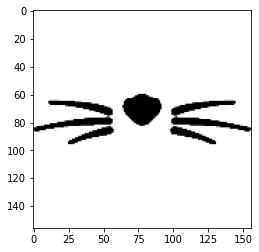

In [15]:
# 이미지 출력
plt.imshow(img_sticker)
plt.show()

- 스티커에 불필요하게 Y축 빈 공간이 많다.
- 스티커의 위치를 저 비어있는 공간 시작점을 고려해야 하는데 이 부분은 합리적이지 않다고 판단.
- 실제로 유효한 스티커의 상단과 하단의 y값을 구해서 이미지를 잘라서 쓰기로 한다.

In [16]:
img_sticker[0][1]

array([255, 255, 255], dtype=uint8)

In [17]:
sum(img_sticker[0][0]), sum(img_sticker[0][0])

(765, 765)

In [18]:
y_area = []

# 픽셀 값을 순회하며 값이 흰색이 아닌 지점의 y값들을 저장한다.
for i in range(len(img_sticker)):
    for j in img_sticker[i]:
        # 바로 위에 출력한 스티커 기준 흰색 영역은 RGB값이 255, 255, 255이므로
        # 그 합계인 765가 아닌 픽셀은 실제 스티커의 영역이라고 할 수 있다.
        if sum(j) != 765: 
            y_area.append(i)

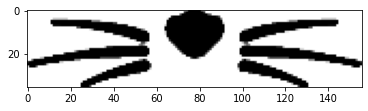

In [19]:
# 이미지 출력
plt.imshow(img_sticker[min(y_area):max(y_area)+1])
plt.show()

In [158]:
# 자른 이미지로 교체
img_sticker = img_sticker[min(y_area):max(y_area)+1]

- Testing

In [159]:
# 스티커 이미지 조정
img_sticker = cv2.resize(img_sticker, (w,h))

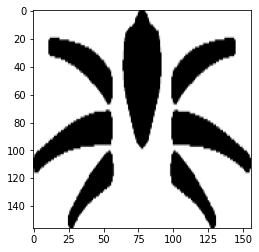

In [160]:
# 이미지 출력
plt.imshow(img_sticker)
plt.show()

## 스티커 위치 확인

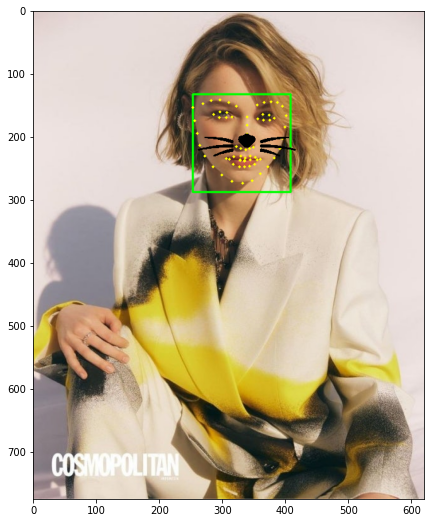

In [20]:
# 스티커 영역
sticker_area = img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]


img_show[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker!=0,sticker_area,img_sticker).astype(np.uint8)

# 이미지 출력
plt.figure(figsize=(7,9))
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

- 적당한 위치에 잘 놓인 것 같다.

# 스티커 적용하기

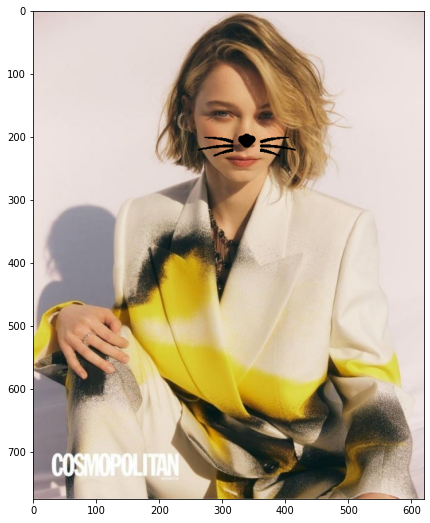

In [21]:
# Bounding Box, Landmark 표시 없는 원본 이미지에 결과 출력

# 스티커 붙이기
sticker_area = img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y +img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker!=0,sticker_area,img_sticker).astype(np.uint8)

# 이미지 출력
plt.figure(figsize=(7,9))
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## 스티커 적용 함수화

- 우선 여러 이미지에 바로 적용하고 문제를 확인해보기 위해 위 일련의 과정을 함수화 한다.

In [138]:
def add_sticker(img, bbox=False, landmarks=False):
    
    # 얼굴 검출
    dlib_rects = detector_hog(img, 1)
    
    if not dlib_rects:
        print("Face Detection Failure")
        return
    
    # 여러 얼굴이 있을 경우를 생각하여 for문으로 작성
    for dlib_rect in dlib_rects: # 찾은 얼굴 영역의 좌표
        l = dlib_rect.left() # 왼쪽
        t = dlib_rect.top() # 위쪽
        r = dlib_rect.right() # 오른쪽
        b = dlib_rect.bottom() # 아래쪽
    
        if bbox == True:
            cv2.rectangle(img, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)
  
    
    # 랜드마크 검출
    list_landmarks = []

    for dlib_rect in dlib_rects:
        points = landmark_predictor(img, dlib_rect)
        list_points = list(map(lambda p: (p.x, p.y), points.parts()))
        list_landmarks.append(list_points)
        
    if landmarks == True:
        for landmark in list_landmarks:
            for point in landmark:
                cv2.circle(img, point, 2, (0, 255, 255), -1)  
    
    if not list_landmarks:
        print("Landmark Detection Failure")
        return

    # 스티커 위치 설정
    coords = []
    for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
        x = landmark[29][0]
        y = landmark[29][1]
        w = h = dlib_rect.width()
        coords.append([x, y, w, h])

    # 스티커 준비
    img_sticker = cv2.imread('./cat-whiskers.png')
    stickers = []
    
    for x, y, w, h in coords
         stickers.append(cv2.resize(img_sticker, (w,h)))
    
    y_area = []
    for i in range(len(img_sticker)):
        for j in img_sticker[i]:
            if sum(j) != 765: 
                y_area.append(i)
    img_sticker = img_sticker[min(y_area):max(y_area)+1]
    
    refined_x = x - w // 2
    refined_y = y

    if refined_x < 0: 
        img_sticker = img_sticker[:, -refined_x:]
        refined_x = 0
    if refined_y < 0:
        img_sticker = img_sticker[-refined_y:, :]
        refined_y = 0
    
    # 스티커 적용
    sticker_area = img[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
    img[refined_y:refined_y+img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker!=0,sticker_area,img_sticker).astype(np.uint8)

    # 이미지 출력
    plt.figure(figsize=(7,9))
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

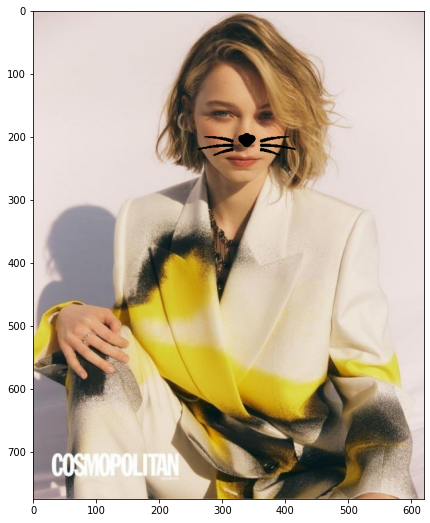

In [23]:
img_bgr = cv2.imread('./emma_fr.png')
add_sticker(img_bgr)

# 문제점 찾아보기

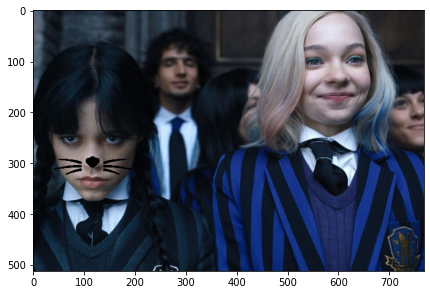

In [135]:
add_sticker(cv2.imread('./emma_wed.png'))

600 119 156 156
292 115 91 91
116 287 156 156


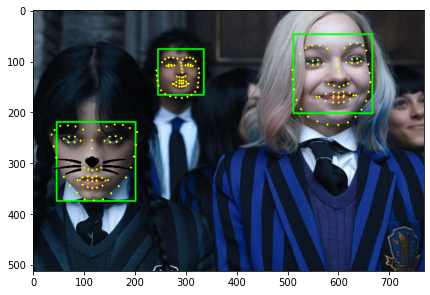

In [139]:
add_sticker(cv2.imread('./emma_wed.png'), True, True)

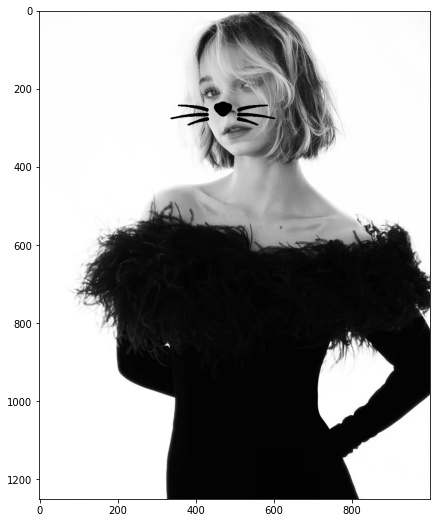

In [24]:
add_sticker(cv2.imread('./emma_l.png'))

- 이상함 발견. 바운딩 박스를 그려서 확인해본다.

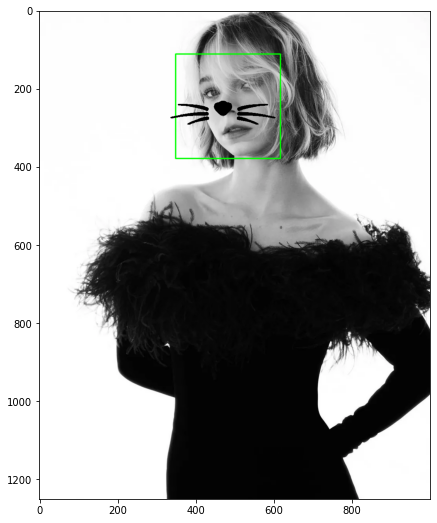

In [25]:
add_sticker(cv2.imread('./emma_l.png'), True)

- 얼굴의 회전각도는 고려하지 않은채 코를 중심으로 좌우 면적이 동일하도록 바운딩 박스가 그려짐
    - 즉, 바운딩박스가 얼굴이 카메라 정면을 보고 있는 경우만 고려했다.
    
- 스티커 또한 회전값을 고려하지 않은채 바운딩박스 기준으로 그려져 있기 때문에 어색함이 나타난다.
    - 즉, 스티커가 얼굴의 회전을 고려하여 함께 회전하여야 어색함을 줄일 수 있을 것이다.

---

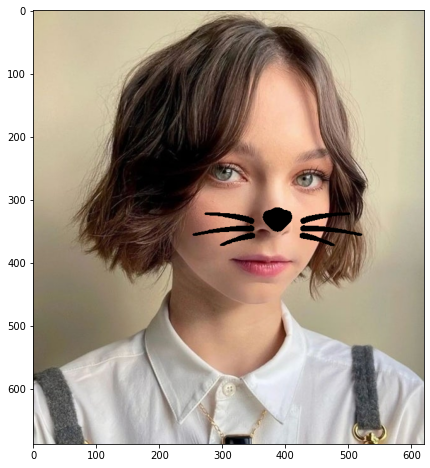

In [28]:
add_sticker(cv2.imread('./emma_r.png'))

- 이 경우는 회전각도가 크지 않아서 그만큼 덜 어색하긴 하다.

- 다만, 사진 기준 오른쪽으로 약간 회전을 했으나 이를 고려하지 않았기 때문에 왼쪽 수염을 코에 붙은 반면 오른쪽은 약간 떨어져 있는 이상한 부분이 발생한다.

- 직전 사진과 동일한 문제

---

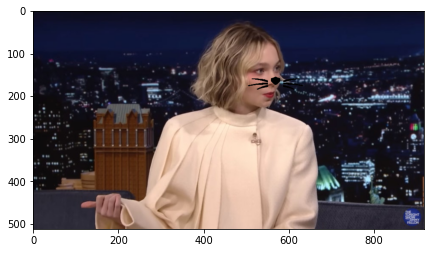

In [57]:
add_sticker(cv2.imread('./emma_side.png'))

- 좀 더 회전이 큰 옆모습으로 시도.
- 역시 같은 문제. 배경 때문에 잘 안 보이지만 수염이 공중에 떠 있다.
---

In [47]:
add_sticker(cv2.imread('./emma_r_rotate.png'))

Face Detection Failure


- 이번 사진에서는 얼굴을 검출하지 못하는 문제가 발생했다.
- 원본 사진 확인 필요.

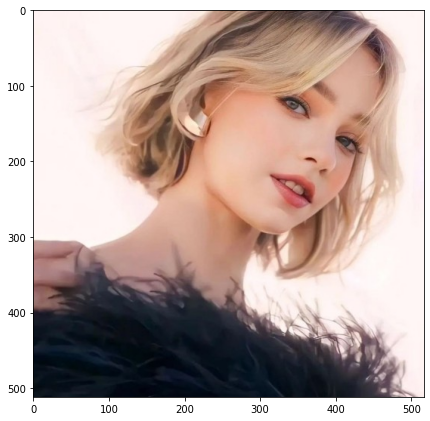

In [49]:
img = cv2.imread('./emma_r_rotate.png') 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(7,9))
plt.imshow(img)
plt.show()

- 이번 사진은 얼굴이 기울어져 있다. 해당 검출기가 기울어진 모습에서는 얼굴을 인식하지 못하는 것은 아닐까?
- 기존에 얼굴을 인식했던 사진을 인위적으로 기울이고 얼굴 검출을 시도해본다.

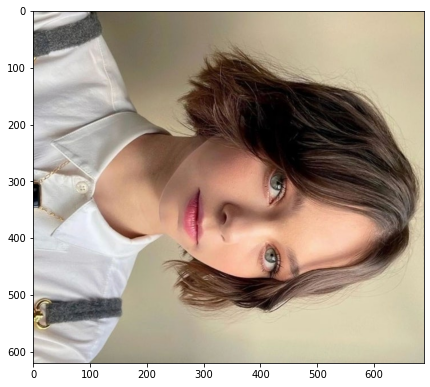

In [54]:
img = cv2.imread('./emma_r.png')
rotate_90 = cv2.rotate(img, cv2.ROTATE_90_CLOCKWISE)
plt.figure(figsize=(7,9))
plt.imshow(cv2.cvtColor(rotate_90, cv2.COLOR_BGR2RGB))
plt.show()

- 앞서 정상적으로 인식했던 이미지를 기울여서 시도.

In [56]:
add_sticker(rotate_90)

Face Detection Failure


- 역시 실패.
- 해당 검출기는 기울기가 있는 얼굴을 검출하지 못하는 문제가 있다.
---

In [58]:
add_sticker(cv2.imread('./emma_zo.png'))

Face Detection Failure


- 이번에도 얼굴 검출 실패.
- 원본 확인

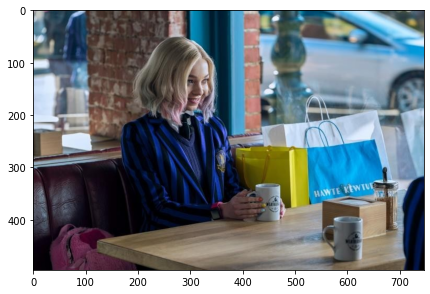

In [60]:
img = cv2.imread('./emma_zo.png') 
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.figure(figsize=(7,9))
plt.imshow(img)
plt.show()

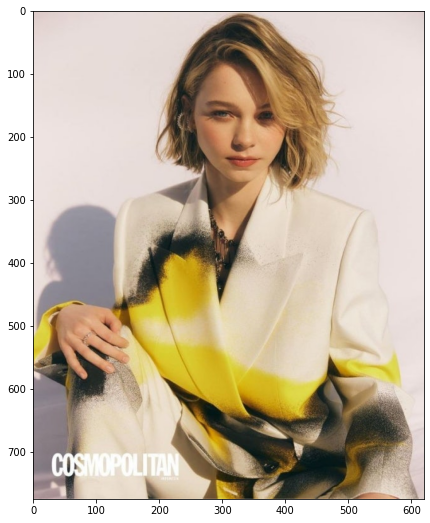

In [61]:
img_bgr = cv2.imread('./emma_fr.png')    # OpenCV로 이미지를 불러옵니다
img_show = img_bgr.copy()      # 출력용 이미지를 따로 보관합니다
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB) # RGB 순서를 변환합니다.


# 이미지 출력
plt.figure(figsize=(7,9))
plt.imshow(img_rgb)
plt.show()

In [101]:
img_show.shape

(775, 620, 3)

In [106]:
temp = np.zeros(img_show.shape, dtype=img_bgr.dtype)
temp.shape

(775, 620, 3)

In [81]:
temp

array([[[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       ...,

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]],

       [[0, 0, 0],
        [0, 0, 0],
        [0, 0, 0],
        ...,
        [0, 0, 0],
        [0, 0, 0],
        [0, 0, 0]]], dtype=uint8)

In [84]:
temp += 255

In [85]:
print(f"img_bgr의 데이터 타입: {img_bgr.dtype}")
print(f"temp의 데이터 타입: {temp.dtype}")

img_bgr의 데이터 타입: uint8
temp의 데이터 타입: uint8


In [86]:
blended_image = cv2.addWeighted(img_bgr, 1, temp, 0.5, 0)

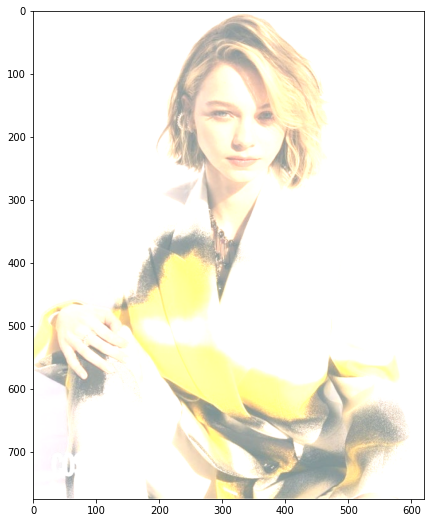

In [87]:
# 이미지 출력
plt.figure(figsize=(7,9))
plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
plt.show()

In [122]:
img_show.shape

(775, 620, 3)

In [123]:
test = list(img_show.shape)
test

[775, 620, 3]

In [124]:
test[-1] += 1
test

[775, 620, 4]

In [125]:
temp = np.zeros(test, dtype=img_bgr.dtype)
temp.shape

(775, 620, 4)

In [126]:
temp

array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       ...,

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

In [127]:
temp[:, :, 3:] = 255
temp

array([[[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       ...,

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        ...,
        [  0,   0,   0, 255],
        [  0,   0,   0, 255],
        [  0,   0,   0, 255]],

       [[  0

In [116]:
img_show

array([[[198, 200, 218],
        [199, 201, 219],
        [199, 201, 219],
        ...,
        [205, 205, 221],
        [205, 205, 221],
        [204, 204, 220]],

       [[199, 201, 219],
        [200, 202, 220],
        [200, 202, 220],
        ...,
        [204, 204, 220],
        [204, 204, 220],
        [204, 204, 220]],

       [[201, 203, 221],
        [201, 203, 221],
        [201, 203, 221],
        ...,
        [205, 205, 221],
        [205, 205, 221],
        [204, 204, 220]],

       ...,

       [[157, 153, 178],
        [157, 153, 178],
        [156, 152, 177],
        ...,
        [200, 202, 220],
        [198, 203, 218],
        [198, 203, 218]],

       [[158, 154, 179],
        [158, 154, 179],
        [158, 154, 179],
        ...,
        [200, 202, 220],
        [198, 203, 218],
        [199, 204, 219]],

       [[173, 170, 192],
        [172, 169, 191],
        [172, 169, 191],
        ...,
        [203, 205, 223],
        [204, 207, 222],
        [204, 207, 222]]

In [128]:
temp[:, :, :3] = img_show

In [129]:
temp

array([[[198, 200, 218, 255],
        [199, 201, 219, 255],
        [199, 201, 219, 255],
        ...,
        [205, 205, 221, 255],
        [205, 205, 221, 255],
        [204, 204, 220, 255]],

       [[199, 201, 219, 255],
        [200, 202, 220, 255],
        [200, 202, 220, 255],
        ...,
        [204, 204, 220, 255],
        [204, 204, 220, 255],
        [204, 204, 220, 255]],

       [[201, 203, 221, 255],
        [201, 203, 221, 255],
        [201, 203, 221, 255],
        ...,
        [205, 205, 221, 255],
        [205, 205, 221, 255],
        [204, 204, 220, 255]],

       ...,

       [[157, 153, 178, 255],
        [157, 153, 178, 255],
        [156, 152, 177, 255],
        ...,
        [200, 202, 220, 255],
        [198, 203, 218, 255],
        [198, 203, 218, 255]],

       [[158, 154, 179, 255],
        [158, 154, 179, 255],
        [158, 154, 179, 255],
        ...,
        [200, 202, 220, 255],
        [198, 203, 218, 255],
        [199, 204, 219, 255]],

       [[173

In [130]:
temp2 = np.zeros(test, dtype=img_bgr.dtype)
temp2.shape

(775, 620, 4)

In [132]:
temp2

array([[[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       ...,

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]],

       [[0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        ...,
        [0, 0, 0, 0],
        [0, 0, 0, 0],
        [0, 0, 0, 0]]], dtype=uint8)

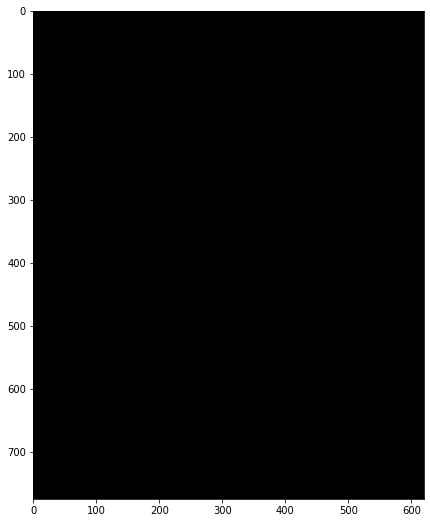

In [131]:
# 이미지 출력
plt.figure(figsize=(7,9))
plt.imshow(cv2.cvtColor(temp2, cv2.COLOR_BGR2RGB))
plt.show()

In [120]:
temp[:, :, 3:] = 100
temp

array([[[198, 200, 218, 100],
        [199, 201, 219, 100],
        [199, 201, 219, 100],
        ...,
        [205, 205, 221, 100],
        [205, 205, 221, 100],
        [204, 204, 220, 100]],

       [[199, 201, 219, 100],
        [200, 202, 220, 100],
        [200, 202, 220, 100],
        ...,
        [204, 204, 220, 100],
        [204, 204, 220, 100],
        [204, 204, 220, 100]],

       [[201, 203, 221, 100],
        [201, 203, 221, 100],
        [201, 203, 221, 100],
        ...,
        [205, 205, 221, 100],
        [205, 205, 221, 100],
        [204, 204, 220, 100]],

       ...,

       [[157, 153, 178, 100],
        [157, 153, 178, 100],
        [156, 152, 177, 100],
        ...,
        [200, 202, 220, 100],
        [198, 203, 218, 100],
        [198, 203, 218, 100]],

       [[158, 154, 179, 100],
        [158, 154, 179, 100],
        [158, 154, 179, 100],
        ...,
        [200, 202, 220, 100],
        [198, 203, 218, 100],
        [199, 204, 219, 100]],

       [[173

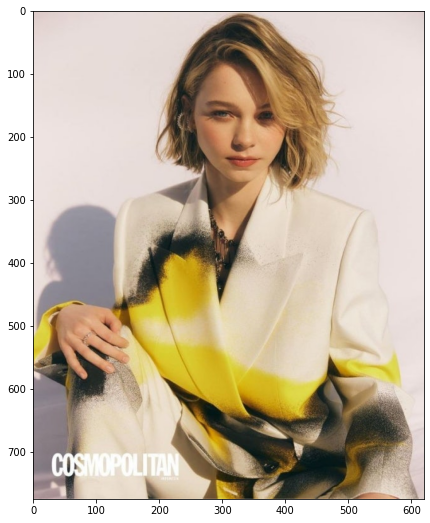

In [121]:
# 이미지 출력
plt.figure(figsize=(7,9))
plt.imshow(cv2.cvtColor(temp, cv2.COLOR_BGR2RGB))
plt.show()

In [133]:
blended_image = cv2.addWeighted(temp, 1, temp2, 0.5, 0)

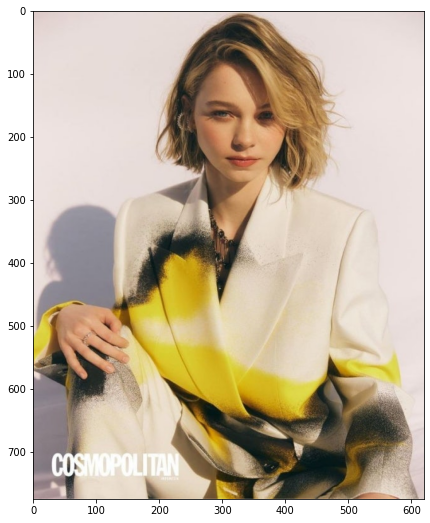

In [134]:
# 이미지 출력
plt.figure(figsize=(7,9))
plt.imshow(cv2.cvtColor(blended_image, cv2.COLOR_BGR2RGB))
plt.show()

In [140]:
coords = []

coords.append([1, 2, 3, 4])

coords

[[1, 2, 3, 4]]

In [141]:
for x, y, w, h in coords:
    print(x, y, w, h)

1 2 3 4
